In [105]:
#Implement Error mitigation circuit with pennylane
%pip install pennylane --upgarde
%pip install pennylane-lightning pennylane-lightning[gpu] pennylane-sf pennylane-qiskit pennylane-cirq
%pip install "mitiq>=0.11"


Usage:   
  /opt/homebrew/opt/python@3.10/bin/python3.10 -m pip install [options] <requirement specifier> [package-index-options] ...
  /opt/homebrew/opt/python@3.10/bin/python3.10 -m pip install [options] -r <requirements file> [package-index-options] ...
  /opt/homebrew/opt/python@3.10/bin/python3.10 -m pip install [options] [-e] <vcs project url> ...
  /opt/homebrew/opt/python@3.10/bin/python3.10 -m pip install [options] [-e] <local project path> ...
  /opt/homebrew/opt/python@3.10/bin/python3.10 -m pip install [options] <archive url/path> ...

no such option: --upgarde
Note: you may need to restart the kernel to use updated packages.
zsh:1: no matches found: pennylane-lightning[gpu]
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [106]:
import pennylane as qml

n_wires = 4

# Describe noise
noise_gate = qml.PhaseDamping
noise_strength = 0.1

# Load devices
dev_ideal = qml.device("default.mixed", wires=n_wires) #circuit in ideal state
dev_noisy = qml.transforms.insert(noise_gate, noise_strength)(dev_ideal) #circuit in nosiy state

In [107]:
from pennylane import numpy as np

np.random.seed(1967)
#np.random.seed(2000)

# Select template to use within circuit and generate parameters
n_layers = 1
template = qml.SimplifiedTwoDesign
weights_shape = template.shape(n_layers, n_wires)
w1, w2 = [2 * np.pi * np.random.random(s) for s in weights_shape]


def circuit(w1, w2):
    template(w1, w2, wires=range(n_wires))
    qml.adjoint(template)(w1, w2, wires=range(n_wires))
    return qml.expval(qml.PauliZ(0))


ideal_qnode = qml.QNode(circuit, dev_ideal)
noisy_qnode = qml.QNode(circuit, dev_noisy)

In [108]:
print(qml.draw(ideal_qnode, expansion_strategy="device")(w1, w2))

0: ──RY(4.56)─╭●──RY(5.93)──RY(-5.93)────────────────────────────────────╭●──RY(-4.56)─┤  <Z>
1: ──RY(3.60)─╰Z──RY(5.90)─╭●──────────RY(5.18)──RY(-5.18)─╭●──RY(-5.90)─╰Z──RY(-3.60)─┤     
2: ──RY(4.05)─╭●──RY(3.32)─╰Z──────────RY(1.07)──RY(-1.07)─╰Z──RY(-3.32)─╭●──RY(-4.05)─┤     
3: ──RY(3.51)─╰Z──RY(3.66)──RY(-3.66)────────────────────────────────────╰Z──RY(-3.51)─┤     


In [109]:
ideal_qnode(w1, w2)

array(1.)

In [110]:
noisy_qnode(w1,w2)

array(0.71729164)

In [111]:
from mitiq import zne, benchmarks
from mitiq.zne.scaling import fold_global
from mitiq.zne.inference import RichardsonFactory
from pennylane.transforms import mitigate_with_zne

extrapolate = RichardsonFactory.extrapolate
scale_factors = [1, 2, 3]

mitigated_qnode = mitigate_with_zne(scale_factors, fold_global, extrapolate)(
    noisy_qnode
)
mitigated_qnode(w1, w2)

0.8985196547410819

In [112]:
with qml.tape.QuantumTape() as circuit:
    template(w1, w2, wires=range(n_wires))
    qml.adjoint(template)(w1, w2, wires=range(n_wires))

In [113]:
scale_factors = [1, 2, 3]
folded_circuits = [fold_global(circuit, scale_factor=s) for s in scale_factors]

for s, c in zip(scale_factors, folded_circuits):
    print(f"Globally-folded circuit with a scale factor of {s}:")
    print(qml.drawer.tape_text(c, decimals=2, max_length=80))

Globally-folded circuit with a scale factor of 1:
0: ──RY(4.56)─╭●──RY(5.93)──RY(-5.93)────────────────────────────────────╭●
1: ──RY(3.60)─╰Z──RY(5.90)─╭●──────────RY(5.18)──RY(-5.18)─╭●──RY(-5.90)─╰Z
2: ──RY(4.05)─╭●──RY(3.32)─╰Z──────────RY(1.07)──RY(-1.07)─╰Z──RY(-3.32)─╭●
3: ──RY(3.51)─╰Z──RY(3.66)──RY(-3.66)────────────────────────────────────╰Z

───RY(-4.56)─┤  
───RY(-3.60)─┤  
───RY(-4.05)─┤  
───RY(-3.51)─┤  
Globally-folded circuit with a scale factor of 2:
0: ──RY(4.56)─╭●──RY(5.93)──RY(-5.93)────────────────────────────────────╭●
1: ──RY(3.60)─╰Z──RY(5.90)─╭●──────────RY(5.18)──RY(-5.18)─╭●──RY(-5.90)─╰Z
2: ──RY(4.05)─╭●──RY(3.32)─╰Z──────────RY(1.07)──RY(-1.07)─╰Z──RY(-3.32)─╭●
3: ──RY(3.51)─╰Z──RY(3.66)──RY(-3.66)────────────────────────────────────╰Z

───RY(-4.56)──RY(4.56)─╭●───────────────────────────────────────────────────────
───RY(-3.60)──RY(3.60)─╰Z──RY(5.90)─╭●──RY(5.18)──RY(-5.18)──RY(5.18)──RY(-5.18)
───RY(-4.05)──RY(4.05)─╭●──RY(3.32)─╰Z──RY(1.07)──RY(-1.07)─

In [114]:
def executor(circuits, dev=dev_noisy):
    # Support both a single circuit and multiple circuit execution
    circuits = [circuits] if isinstance(circuits, qml.tape.QuantumTape) else circuits

    circuits_with_meas = []

    # Loop through circuits and add on measurement
    for c in circuits:
        with qml.tape.QuantumTape() as circuit_with_meas:
            for o in c.operations:
                qml.apply(o)
            qml.expval(qml.PauliZ(0))
        circuits_with_meas.append(circuit_with_meas)

    return qml.execute(circuits_with_meas, dev, gradient_fn=None)

In [115]:
executor(folded_circuits, dev=dev_ideal)

[array([1.]), array([1.]), array([1.])]

In [116]:
executor(folded_circuits, dev=dev_noisy)

[array([0.71729164]), array([0.54368629]), array([0.3777036])]

In [117]:
# Evaluate noise-scaled expectation values
noisy_expectation_values = executor(folded_circuits, dev=dev_noisy)

# Initialize extrapolation method
fac = RichardsonFactory(scale_factors)

# Load data into extrapolation factory
for x, y in zip(scale_factors, noisy_expectation_values):
    fac.push({"scale_factor": x}, y)

# Run extrapolation
zero_noise = fac.reduce()

print(f"ZNE result: {zero_noise[0]}")

ZNE result: 0.8985196547410819


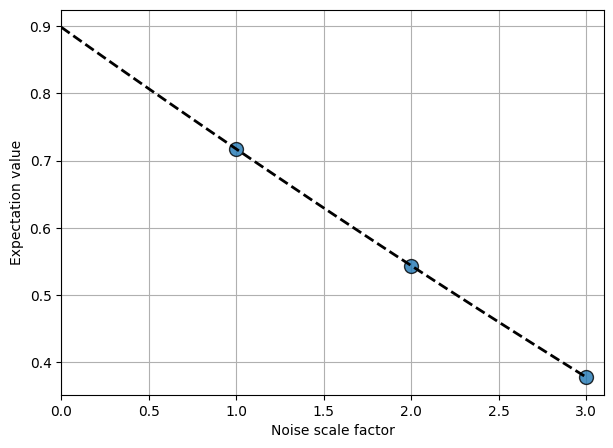

In [118]:
_ = fac.plot_fit()

In [ ]:
dev = 

In [119]:
mitigated_qnode = mitigate_with_zne(scale_factors, folding, extrapolate)(qnode)

NameError: name 'qnode' is not defined

In [ ]:
from mitiq.zne.scaling import fold_gates_at_random as folding

extrapolate = RichardsonFactory.extrapolate


@mitigate_with_zne(scale_factors, folding, extrapolate, reps_per_factor=100)
@qml.qnode(dev_noisy)
def mitigated_qnode(w1, w2):
    template(w1, w2, wires=range(n_wires))
    qml.adjoint(template)(w1, w2, wires=range(n_wires))
    return qml.expval(qml.PauliZ(0))


mitigated_qnode(w1, w2)

1.0051813776184257

In [ ]:
for _ in range(3):
    print(qml.drawer.tape_text(folding(circuit, scale_factor=1.1), decimals=2, max_length=80))

0: ──RY(3.58)─╭●──────────RY(2.36)──RY(-2.36)───────────────────────────────
1: ──RY(3.55)─╰Z──────────RY(3.34)──────────────────────╭●──────────RY(1.49)
2: ──RY(3.07)──RY(-3.07)──RY(3.07)─╭●──────────RY(0.43)─╰Z──────────RY(1.01)
3: ──RY(2.11)──────────────────────╰Z──────────RY(3.67)──RY(-3.67)──────────

───────────────────────────╭●──RY(-3.58)─┤  
───RY(-1.49)─╭●──RY(-3.34)─╰Z──RY(-3.55)─┤  
───RY(-1.01)─╰Z──RY(-0.43)─╭●──RY(-3.07)─┤  
───────────────────────────╰Z──RY(-2.11)─┤  
0: ──RY(3.58)─╭●──RY(2.36)──RY(-2.36)────────────────────────────────────╭●
1: ──RY(3.55)─╰Z──RY(3.34)─╭●──────────RY(1.49)──RY(-1.49)─╭●──RY(-3.34)─╰Z
2: ──RY(3.07)─╭●──RY(0.43)─╰Z──────────RY(1.01)──RY(-1.01)─╰Z──RY(-0.43)─╭●
3: ──RY(2.11)─╰Z──RY(3.67)──RY(-3.67)────────────────────────────────────╰Z

───RY(-3.58)───────────────┤  
───RY(-3.55)───────────────┤  
──╭●─────────╭●──RY(-3.07)─┤  
──╰Z─────────╰Z──RY(-2.11)─┤  
0: ──RY(3.58)─╭●──RY(2.36)──RY(-2.36)──────────────────────────────────────────
1:

In [ ]:
from mitiq.zne import execute_with_zne
from mitiq.zne.inference import AdaExpFactory

factory = AdaExpFactory(steps=20)

execute_with_zne(circuit, executor, factory=factory, scale_noise=fold_global)

ExtrapolationError: The extrapolation fit failed to converge. The problem may be solved by switching to a more stable extrapolation model such as `LinearFactory`.

In [ ]:
from qiskit.test.mock import FakeLima
from qiskit.providers.aer.noise import NoiseModel

backend = FakeLima()
noise_model = NoiseModel.from_backend(backend)

In [ ]:
n_wires = 4

dev_ideal = qml.device("default.qubit", wires=n_wires)
dev_noisy = qml.device(
    "qiskit.aer",
    wires=n_wires,
    noise_model=noise_model,
    optimization_level=0,
    shots=10000,
)

In [ ]:
params = np.load("./Error_mitigation/params.npy")

In [ ]:
from pennylane import qchem

# Describe quantum chemistry problem
symbols = ["H", "H"]
distances = np.arange(0.5, 3.0, 0.25)

ideal_energies = []
noisy_energies = []

for r, phi in zip(distances, params):
    # Assume atoms lie on the Z axis
    coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, r])

    # Load qubit Hamiltonian
    H, _ = qchem.molecular_hamiltonian(symbols, coordinates)

    # Define ansatz circuit
    def qchem_circuit(phi):
        qml.PauliX(wires=0)
        qml.PauliX(wires=1)
        qml.DoubleExcitation(phi, wires=range(n_wires))
        return qml.expval(H)

    ideal_energy = qml.QNode(qchem_circuit, dev_ideal)
    noisy_energy = qml.QNode(qchem_circuit, dev_noisy)

    ideal_energies.append(ideal_energy(phi))
    noisy_energies.append(noisy_energy(phi))

In [ ]:
mitig_energies = []

for r, phi in zip(distances, params):
    # Assume atoms lie on the Z axis
    coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, r])

    # Load qubit Hamiltonian
    H, _ = qchem.molecular_hamiltonian(symbols, coordinates)

    # Define ansatz circuit
    with qml.tape.QuantumTape() as circuit:
        qml.PauliX(wires=0)
        qml.PauliX(wires=1)
        qml.DoubleExcitation(phi, wires=range(n_wires))

    # Define custom executor that expands Hamiltonian measurement
    # into a linear combination of tensor products of Pauli
    # operators.
    def executor(circuit):

        # Add Hamiltonian measurement to circuit
        with qml.tape.QuantumTape() as circuit_with_meas:
            for o in circuit.operations:
                qml.apply(o)
            qml.expval(H)

        # Expand Hamiltonian measurement into tensor product of
        # of Pauli operators. We get a list of circuits to execute
        # and a postprocessing function to combine the results into
        # a single number.
        circuits, postproc = qml.transforms.hamiltonian_expand(
            circuit_with_meas, group=False
        )
        circuits_executed = qml.execute(circuits, dev_noisy, gradient_fn=None)
        return postproc(circuits_executed)

    mitig_energy = execute_with_zne(circuit, executor, scale_noise=fold_global)
    mitig_energies.append(mitig_energy)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(ideal_energies, label="ideal")
plt.plot(noisy_energies, label="noisy")
plt.plot(mitig_energies, label="mitigated")
plt.xlabel("Bond length (Bohr)")
plt.ylabel("Total energy (Hartree)")
plt.legend()
plt.show()